In [10]:
import os, json, numpy as np, pandas as pd, joblib
from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor


In [11]:
df = pd.read_csv("data_encoded (3).csv")
print("Loaded shape:", df.shape)
df.head()

Loaded shape: (1325, 7)


,age,bmi,children,region,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,3,16884.92400,0,1
1,18.0,33.770,1.0,2,1725.55230,1,0
2,28.0,33.000,3.0,2,4449.46200,1,0
3,33.0,22.705,0.0,1,21984.47061,1,0
4,32.0,28.880,0.0,1,3866.85520,1,0


In [12]:
cands = [c for c in df.columns if c.lower() in {"charges", "price", "target", "y"}]
target = cands[0] if cands else df.columns[-1]
print("Target column:", target)

for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)
    elif df[col].dtype == object:
        uq = set(str(x).strip().lower() for x in df[col].dropna().unique())
        if uq <= {"true","false"}:
            df[col] = df[col].astype(str).str.strip().str.lower().map({"true":1,"false":0})

before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print(f"Dropped duplicates: {before - len(df)}")

# Split features/target
y = df[target].astype(float)
X = df.drop(columns=[target])

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)


Target column: charges
Dropped duplicates: 0
Numeric cols: ['age', 'bmi', 'children', 'region', 'sex_male', 'smoker_yes']
Categorical cols: []


In [13]:
num_prep = SimpleImputer(strategy="median")
cat_prep = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
]) if cat_cols else "drop"

preprocess = ColumnTransformer(
    [("num", num_prep, num_cols), ("cat", cat_prep, cat_cols)],
    remainder="drop"
)

# Split (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train.shape, X_test.shape

((1060, 6), (265, 6))

In [14]:
hgb_mae = Pipeline([
    ("prep", preprocess),
    ("est", HistGradientBoostingRegressor(
        loss="absolute_error",      # optimizes MAE directly
        learning_rate=0.08,
        max_iter=600,
        max_depth=None,
        l2_regularization=0.01,
        random_state=42
    ))
])

hgb_mae.fit(X_train, y_train)
pred_a = hgb_mae.predict(X_test)
mae_a = mean_absolute_error(y_test, pred_a)
print(f"Model A (HGB-MAE) Test MAE: {mae_a:,.2f}")


Model A (HGB-MAE) Test MAE: 2,099.31


In [15]:
class LogHGB:
    """Train HGB on log1p(y); predict with expm1."""
    def __init__(self, prep):
        self.prep = prep
        self.est = HistGradientBoostingRegressor(
            loss="squared_error",
            learning_rate=0.08,
            max_iter=900,
            max_depth=None,
            l2_regularization=0.01,
            random_state=42
        )
        self.fitted_ = False

    def fit(self, X, y):
        Xp = self.prep.fit_transform(X, y)
        self.est.fit(Xp, np.log1p(y))
        self.fitted_ = True
        return self

    def predict(self, X):
        Xp = self.prep.transform(X)
        return np.expm1(self.est.predict(Xp))

log_hgb = LogHGB(preprocess).fit(X_train, y_train)
pred_b = log_hgb.predict(X_test)
mae_b = mean_absolute_error(y_test, pred_b)
print(f"Model B (Log-HGB) Test MAE: {mae_b:,.2f}")


Model B (Log-HGB) Test MAE: 3,944.60


In [18]:
models = {
    # Linear / kernel / instance-based (scaled)
    "LinearRegression": Pipeline([
        ("prep", preprocess_scaled),
        ("est", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("prep", preprocess_scaled),
        ("est", Ridge(alpha=5.0, random_state=42))
    ]),
    "SVR_rbf": Pipeline([
        ("prep", preprocess_scaled),
        ("est", SVR(C=10.0, epsilon=0.1, kernel="rbf"))
    ]),
    "KNN": Pipeline([
        ("prep", preprocess_scaled),
        ("est", KNeighborsRegressor(n_neighbors=7, weights="distance"))
    ]),

    "RandomForest": Pipeline([
        ("prep", preprocess_basic),
        ("est", RandomForestRegressor(n_estimators=700, max_depth=None, random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ("prep", preprocess_basic),
        ("est", GradientBoostingRegressor(
            loss="absolute_error", learning_rate=0.06,
            n_estimators=1000, max_depth=3, subsample=0.9, random_state=42
        ))
    ]),
    "HistGradientBoosting": Pipeline([
        ("prep", preprocess_basic),
        ("est", HistGradientBoostingRegressor(
            loss="absolute_error", learning_rate=0.07,
            max_iter=900, max_depth=None, l2_regularization=0.01, random_state=42
        ))
    ]),
}


class LogHGB:
    """Train HGB on log1p(y); predict with expm1."""
    def __init__(self, prep):
        self.prep = prep
        self.est = HistGradientBoostingRegressor(
            loss="squared_error", learning_rate=0.07,
            max_iter=1200, max_depth=None, l2_regularization=0.01, random_state=42
        )
        self.fitted_ = False

    def fit(self, X, y):
        Xp = self.prep.fit_transform(X, y)
        self.est.fit(Xp, np.log1p(y))
        self.fitted_ = True
        return self

    def predict(self, X):
        Xp = self.prep.transform(X)
        return np.expm1(self.est.predict(Xp))


In [19]:
leaderboard = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    leaderboard.append((name, mae))


log_hgb = LogHGB(preprocess_basic).fit(X_train, y_train)
pred_log = log_hgb.predict(X_test)
mae_log = mean_absolute_error(y_test, pred_log)
leaderboard.append(("Log-HistGradientBoosting", mae_log))


leaderboard.sort(key=lambda x: x[1])


print("=== Leaderboard (lower MAE is better) ===")
for rank, (name, mae) in enumerate(leaderboard, 1):
    print(f"{rank:>2}. {name:28s}  MAE = {mae:,.2f}")

best_name, best_mae = leaderboard[0]
print("\nBest model so far:", best_name, "with Test MAE =", f"{best_mae:,.2f}")


=== Leaderboard (lower MAE is better) ===
 1. HistGradientBoosting          MAE = 2,053.08
 2. GradientBoosting              MAE = 2,152.16
 3. KNN                           MAE = 3,226.95
 4. RandomForest                  MAE = 3,315.59
 5. Log-HistGradientBoosting      MAE = 4,013.44
 6. LinearRegression              MAE = 4,531.45
 7. Ridge                         MAE = 4,534.91
 8. SVR_rbf                       MAE = 7,547.44

Best model so far: HistGradientBoosting with Test MAE = 2,053.08


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error


fitted_models = dict(models)
fitted_models["Log-HistGradientBoosting"] = log_hgb

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), 1e-8)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

rows = []
pred_cache = {}
for name, mdl in fitted_models.items():
    yp = mdl.predict(X_test)
    pred_cache[name] = yp
    mae = mean_absolute_error(y_test, yp)
    rmse = np.sqrt(np.mean((y_test - yp)**2))
    r2 = r2_score(y_test, yp)
    medae = median_absolute_error(y_test, yp)
    mp = mape(y_test, yp)
    rows.append(dict(Model=name, MAE=mae, RMSE=rmse, R2=r2, MedAE=medae, MAPE=mp))

metrics_df = pd.DataFrame(rows).sort_values("MAE").reset_index(drop=True)
metrics_df


,Model,MAE,RMSE,R2,MedAE,MAPE
0,HistGradientBoosting,2053.081611,5692.663043,0.746029,182.451457,10.984347
1,GradientBoosting,2152.164653,5709.584917,0.744517,137.041627,10.209859
2,KNN,3226.950223,5819.708550,0.734567,1343.371081,30.406337
3,RandomForest,3315.588773,5930.366573,0.724377,1313.432205,34.547613
4,Log-HistGradientBoosting,4013.435169,6842.890704,0.633029,1676.443372,33.005674
5,LinearRegression,4531.453110,6749.730067,0.642953,2412.457077,41.604674
6,Ridge,4534.912911,6749.533547,0.642973,2430.603648,41.727613
7,SVR_rbf,7547.440940,11634.953917,-0.060919,4592.917081,90.297443


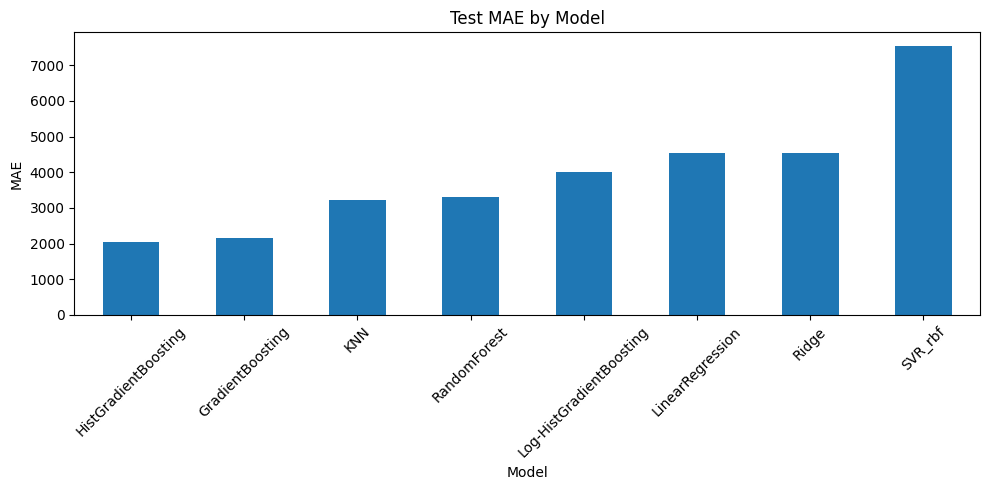

In [22]:
import matplotlib.pyplot as plt

ax = metrics_df.sort_values("MAE").plot(kind="bar", x="Model", y="MAE", legend=False, figsize=(10,5), rot=45)
plt.title("Test MAE by Model")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()


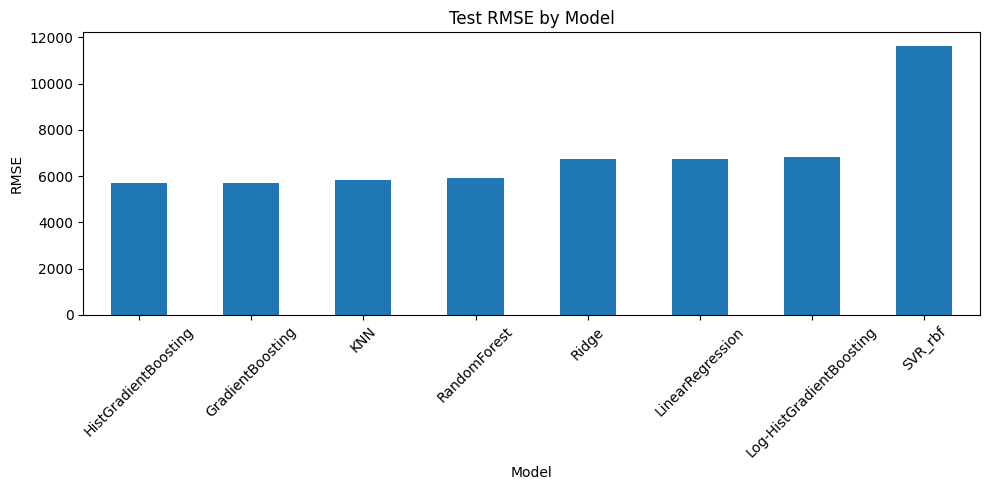

In [23]:
import matplotlib.pyplot as plt

ax = metrics_df.sort_values("RMSE").plot(kind="bar", x="Model", y="RMSE", legend=False, figsize=(10,5), rot=45)
plt.title("Test RMSE by Model")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


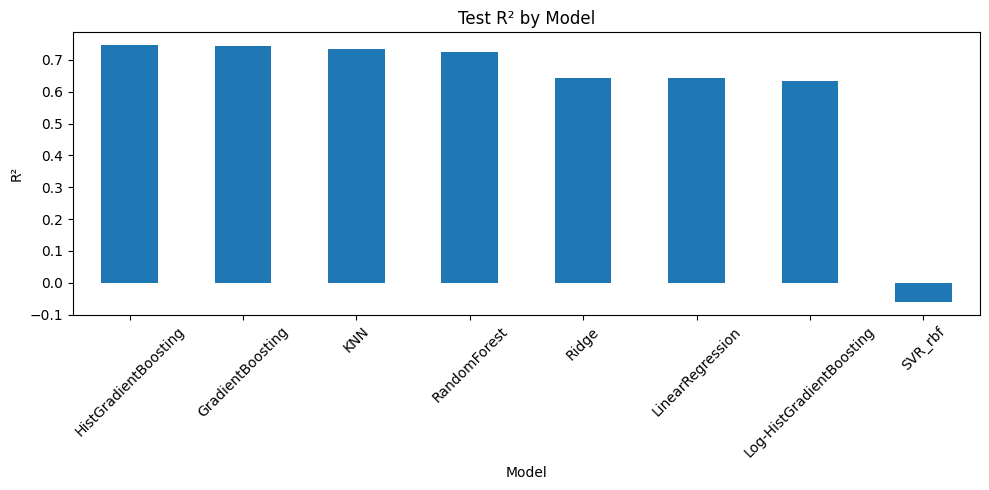

In [24]:
import matplotlib.pyplot as plt

ax = metrics_df.sort_values("R2", ascending=False).plot(kind="bar", x="Model", y="R2", legend=False, figsize=(10,5), rot=45)
plt.title("Test R² by Model")
plt.ylabel("R²")
plt.tight_layout()
plt.show()


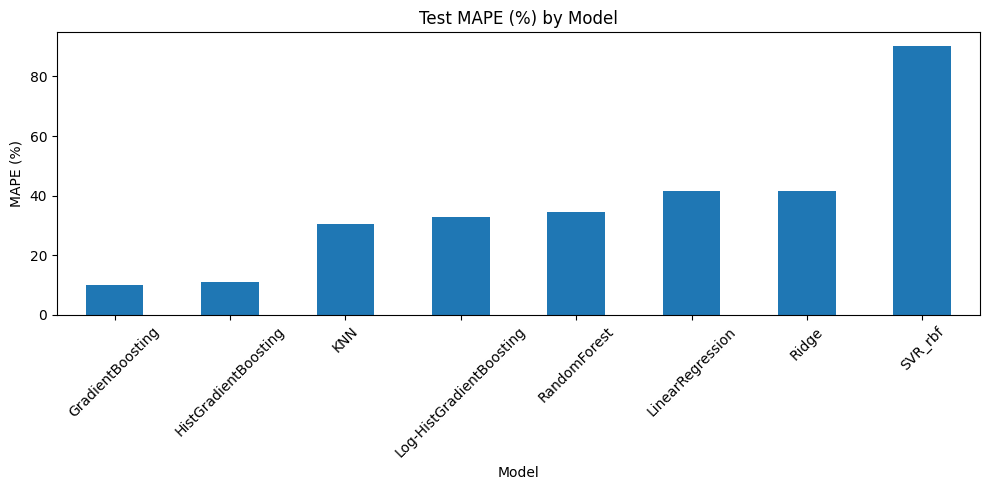

In [25]:
import matplotlib.pyplot as plt

ax = metrics_df.sort_values("MAPE").plot(kind="bar", x="Model", y="MAPE", legend=False, figsize=(10,5), rot=45)
plt.title("Test MAPE (%) by Model")
plt.ylabel("MAPE (%)")
plt.tight_layout()
plt.show()


In [33]:
rank_df = metrics_df.copy()

# Ranks: lower is better for these
for col in ["MAE","RMSE","MedAE","MAPE"]:
    rank_df[col+"_rank"] = rank_df[col].rank(method="min", ascending=True)

# R2: higher is better
rank_df["R2_rank"] = rank_df["R2"].rank(method="min", ascending=False)

# Composite: average of all ranks
rank_cols = ["MAE_rank","RMSE_rank","MedAE_rank","MAPE_rank","R2_rank"]
rank_df["CompositeRank"] = rank_df[rank_cols].mean(axis=1)

rank_df = rank_df.sort_values("CompositeRank").reset_index(drop=True)
rank_df_display = rank_df[["Model","CompositeRank","MAE","RMSE","R2","MedAE","MAPE"]]
rank_df_display


,Model,CompositeRank,MAE,RMSE,R2,MedAE,MAPE
0,HistGradientBoosting,1.4,2053.081611,5692.663043,0.746029,182.451457,10.984347
1,GradientBoosting,1.6,2152.164653,5709.584917,0.744517,137.041627,10.209859
2,KNN,3.2,3226.950223,5819.708550,0.734567,1343.371081,30.406337
3,RandomForest,4.0,3315.588773,5930.366573,0.724377,1313.432205,34.547613
4,Log-HistGradientBoosting,5.6,4013.435169,6842.890704,0.633029,1676.443372,33.005674
5,LinearRegression,6.0,4531.453110,6749.730067,0.642953,2412.457077,41.604674
6,Ridge,6.2,4534.912911,6749.533547,0.642973,2430.603648,41.727613
7,SVR_rbf,8.0,7547.440940,11634.953917,-0.060919,4592.917081,90.297443


In [34]:
best_overall = rank_df.iloc[0]["Model"]
second_overall = rank_df.iloc[1]["Model"]

print("Best two by composite ranking:")
print(rank_df_display.head(2))

print("\nDeduction:")
print(f"1) {best_overall} — best blend of low MAE/RMSE/MedAE/MAPE and strong R².")
print(f"2) {second_overall} — consistently strong across metrics, close to the top.")


Best two by composite ranking:
                  Model  CompositeRank          MAE         RMSE        R2  \
0  HistGradientBoosting            1.4  2053.081611  5692.663043  0.746029   
1      GradientBoosting            1.6  2152.164653  5709.584917  0.744517   

        MedAE       MAPE  
0  182.451457  10.984347  
1  137.041627  10.209859  

Deduction:
1) HistGradientBoosting — best blend of low MAE/RMSE/MedAE/MAPE and strong R².
2) GradientBoosting — consistently strong across metrics, close to the top.


In [26]:
top2 = metrics_df.nsmallest(2, "MAE").copy()
best_name = top2.iloc[0]["Model"]
second_name = top2.iloc[1]["Model"]
print("Top 2 by MAE:")
print(top2[["Model","MAE","RMSE","R2","MedAE","MAPE"]])


Top 2 by MAE:
                  Model          MAE         RMSE        R2       MedAE  \
0  HistGradientBoosting  2053.081611  5692.663043  0.746029  182.451457   
1      GradientBoosting  2152.164653  5709.584917  0.744517  137.041627   

        MAPE  
0  10.984347  
1  10.209859  


###Best model


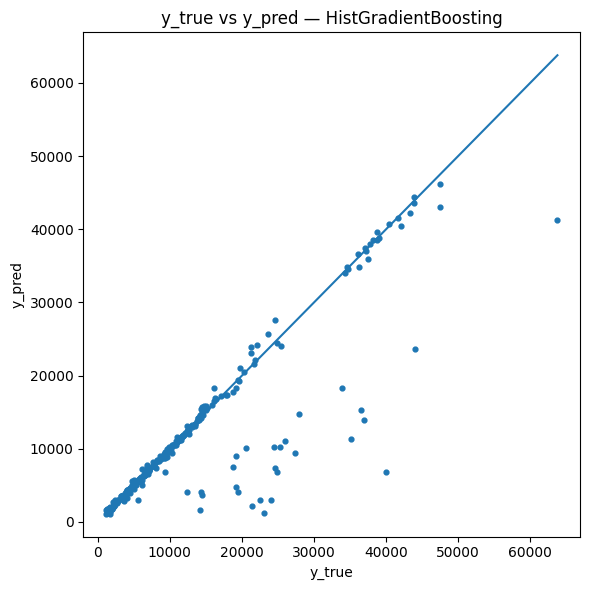

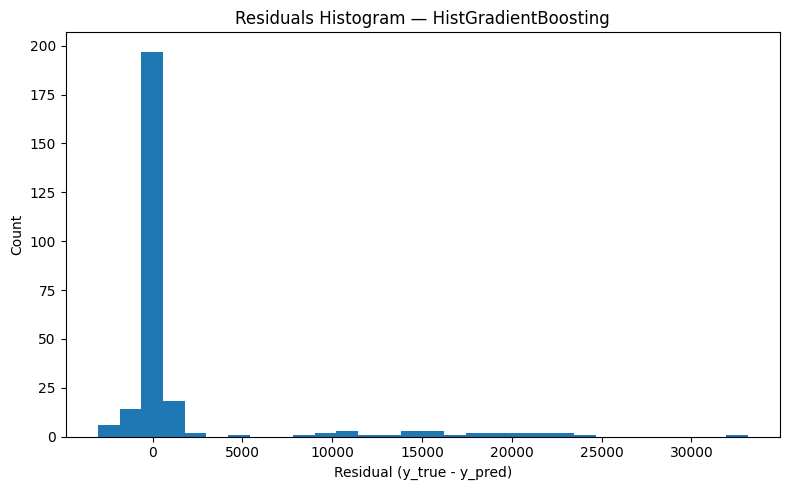

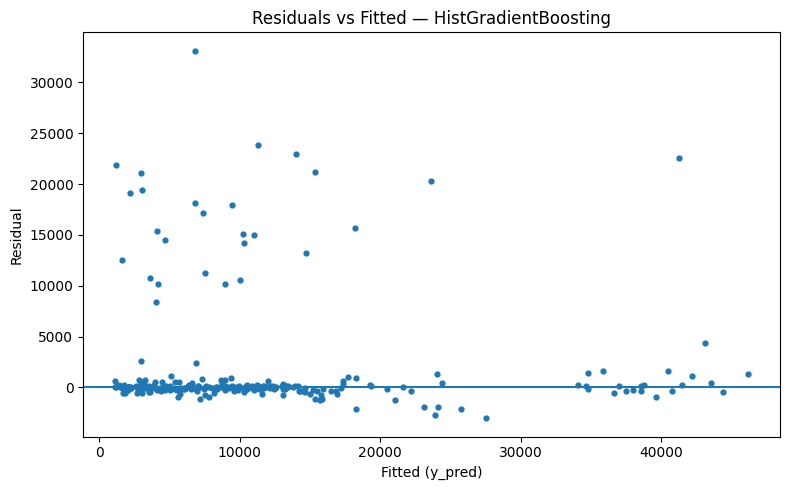

In [31]:
import matplotlib.pyplot as plt
best_pred = pred_cache[best_name]
res_best = y_test - best_pred

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, s=12)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.title(f"y_true vs y_pred — {best_name}")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.hist(res_best, bins=30)
plt.title(f"Residuals Histogram — {best_name}")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(best_pred, res_best, s=12)
plt.axhline(0)
plt.title(f"Residuals vs Fitted — {best_name}")
plt.xlabel("Fitted (y_pred)")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()


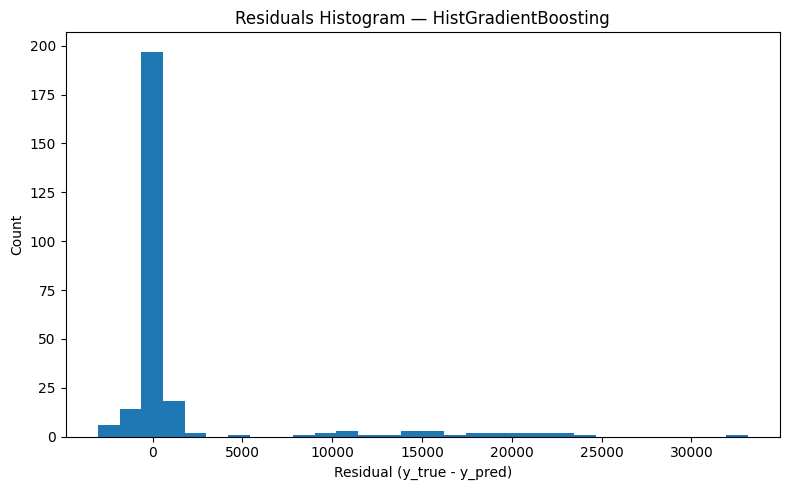

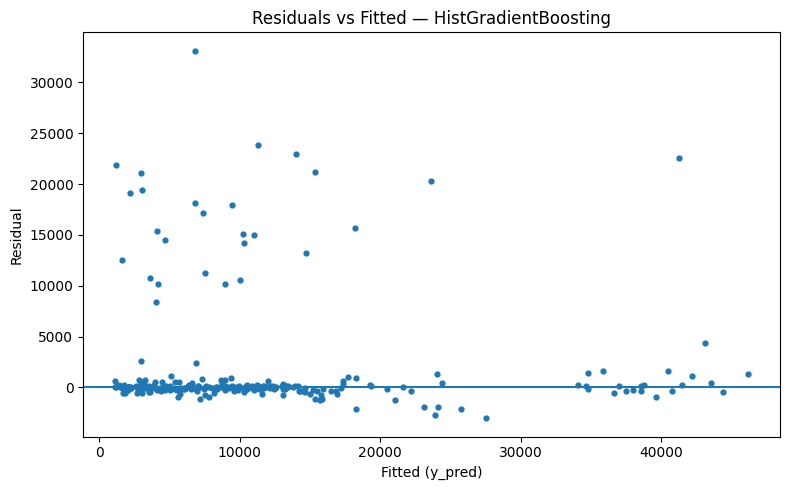

###second best model

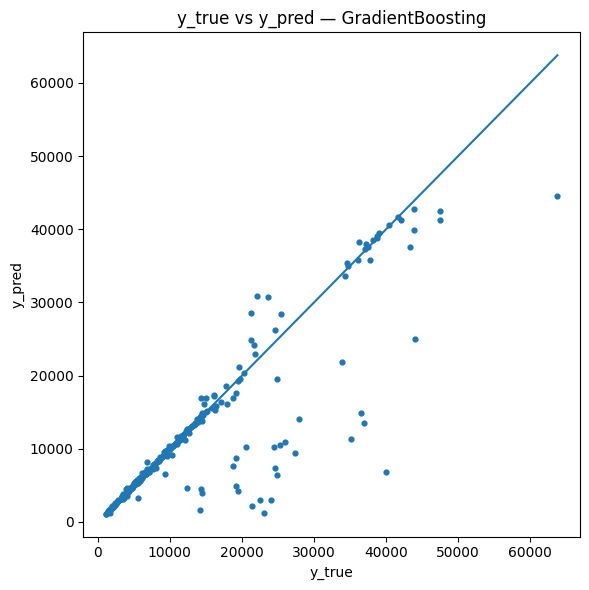

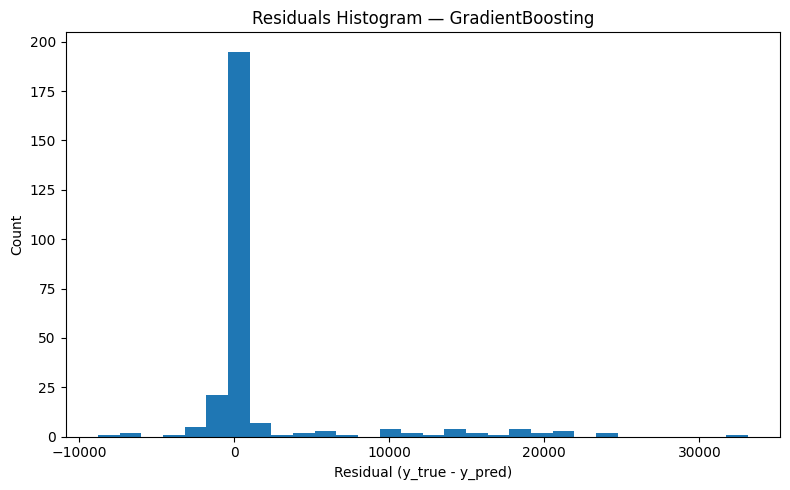

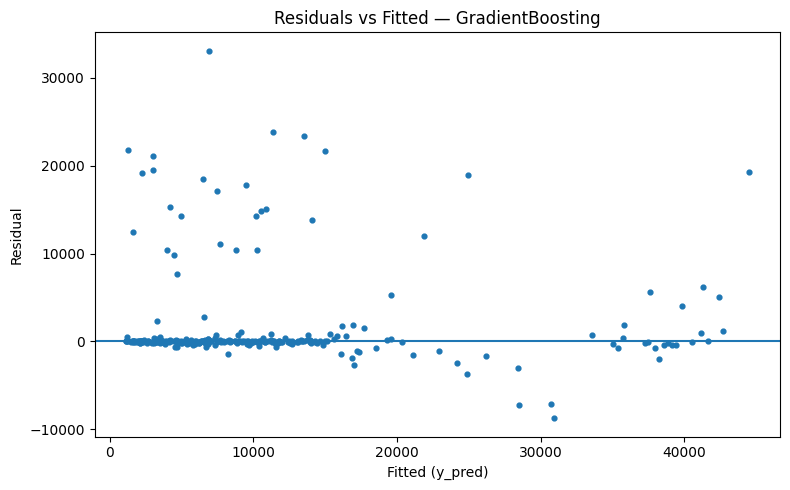

In [30]:
import matplotlib.pyplot as plt
second_pred = pred_cache[second_name]
res_second = y_test - second_pred

plt.figure(figsize=(6,6))
plt.scatter(y_test, second_pred, s=12)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.title(f"y_true vs y_pred — {second_name}")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(res_second, bins=30)
plt.title(f"Residuals Histogram — {second_name}")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(second_pred, res_second, s=12)
plt.axhline(0)
plt.title(f"Residuals vs Fitted — {second_name}")
plt.xlabel("Fitted (y_pred)")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()


###search paramethers for the best two models

In [36]:
from scipy.stats import loguniform, uniform
from sklearn.model_selection import RandomizedSearchCV, KFold
hgb_base = Pipeline([
    ("prep", preprocess_basic),
    ("est", HistGradientBoostingRegressor(
        loss="absolute_error",     # optimizes MAE
        random_state=42
    ))
])

gbr_base = Pipeline([
    ("prep", preprocess_basic),
    ("est", GradientBoostingRegressor(
        loss="absolute_error",
        random_state=42
    ))
])

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

# ---- HGB search space ----
hgb_param_dist = {
    "est__learning_rate": uniform(0.03, 0.12),
    "est__max_iter": [600, 900, 1200, 1500, 2000],
    "est__max_depth": [None, 3, 5, 7, 9],
    "est__min_samples_leaf": [5, 10, 20, 30, 50],
    "est__l2_regularization": loguniform(1e-5, 1e-1),
    "est__max_bins": [128, 255],
    "est__early_stopping": [True],
    "est__validation_fraction": [0.1, 0.15],
    "est__n_iter_no_change": [50, 100],
    "est__tol": [1e-7, 1e-5],
}

hgb_search = RandomizedSearchCV(
    estimator=hgb_base,
    param_distributions=hgb_param_dist,
    n_iter=40,
    scoring="neg_mean_absolute_error",
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# ---- GBR search space ----
gbr_param_dist = {
    "est__learning_rate": loguniform(1e-2, 2e-1),
    "est__n_estimators": [600, 900, 1200, 1600, 2000],
    "est__max_depth": [2, 3, 4, 5],
    "est__subsample": [0.6, 0.8, 0.9, 1.0],
    "est__min_samples_leaf": [1, 3, 5, 10, 20],
    "est__min_samples_split": [2, 5, 10, 20],
    "est__max_features": ["sqrt", "log2", None, 0.6, 0.8, 1.0],
    "est__loss": ["absolute_error", "huber"],
    "est__alpha": [0.85, 0.9, 0.95],
    "est__validation_fraction": [0.1, 0.15],
    "est__n_iter_no_change": [20, 40],
    "est__tol": [1e-4, 1e-3],
}

gbr_search = RandomizedSearchCV(
    estimator=gbr_base,
    param_distributions=gbr_param_dist,
    n_iter=40,
    scoring="neg_mean_absolute_error",
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

In [37]:
hgb_search.fit(X_train, y_train)
gbr_search.fit(X_train, y_train)

print("Best HGB CV MAE:", -hgb_search.best_score_)
print("Best HGB params:", hgb_search.best_params_)

print("\nBest GBR CV MAE:", -gbr_search.best_score_)
print("Best GBR params:", gbr_search.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best HGB CV MAE: 2128.6957574003
Best HGB params: {'est__early_stopping': True, 'est__l2_regularization': np.float64(0.006070874110546389), 'est__learning_rate': np.float64(0.13300305657764638), 'est__max_bins': 255, 'est__max_depth': 5, 'est__max_iter': 1500, 'est__min_samples_leaf': 20, 'est__n_iter_no_change': 100, 'est__tol': 1e-07, 'est__validation_fraction': 0.1}

Best GBR CV MAE: 2062.0798844128785
Best GBR params: {'est__alpha': 0.85, 'est__learning_rate': np.float64(0.06358606736176979), 'est__loss': 'huber', 'est__max_depth': 3, 'est__max_features': 0.8, 'est__min_samples_leaf': 10, 'est__min_samples_split': 2, 'est__n_estimators': 600, 'est__n_iter_no_change': 20, 'est__subsample': 0.9, 'est__tol': 0.0001, 'est__validation_fraction': 0.15}


In [38]:
prev_hgb = models["HistGradientBoosting"]
prev_gbr = models["GradientBoosting"]

hgb_tuned = hgb_search.best_estimator_
gbr_tuned = gbr_search.best_estimator_

def full_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2   = r2_score(y_true, y_pred)
    medae= median_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100.0
    return dict(MAE=mae, RMSE=rmse, R2=r2, MedAE=medae, MAPE=mape)
eval_rows = []
for label, mdl in [
    ("HGB_prev", prev_hgb),
    ("HGB_tuned", hgb_tuned),
    ("GBR_prev", prev_gbr),
    ("GBR_tuned", gbr_tuned),
]:
    yp = mdl.predict(X_test)
    m  = full_metrics(y_test, yp)
    m.update(Model=label)
    eval_rows.append(m)

tuned_df = pd.DataFrame(eval_rows).sort_values("MAE").reset_index(drop=True)
tuned_df


,MAE,RMSE,R2,MedAE,MAPE,Model
0,2050.535286,5643.027073,0.750439,167.252684,10.162273,HGB_tuned
1,2053.081611,5692.663043,0.746029,182.451457,10.984347,HGB_prev
2,2123.964557,5627.116329,0.751844,314.532630,12.339106,GBR_tuned
3,2152.164653,5709.584917,0.744517,137.041627,10.209859,GBR_prev


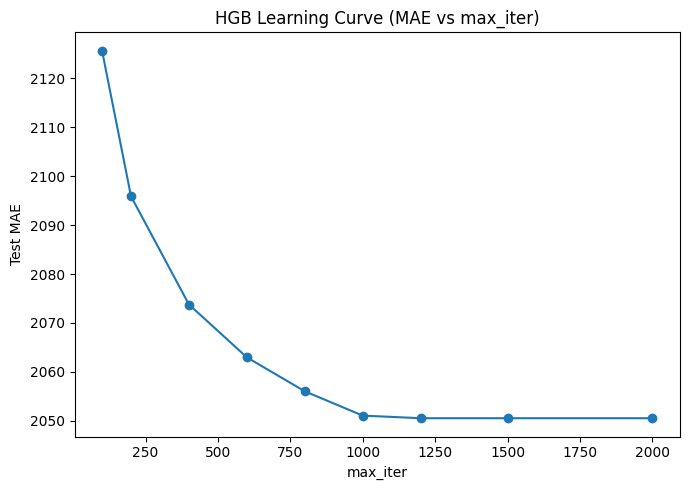

In [39]:
from copy import deepcopy

iters = [100, 200, 400, 600, 800, 1000, 1200, 1500, 2000]
mae_curve = []

base = deepcopy(hgb_tuned)
for it in iters:
    step = deepcopy(base)
    step.set_params(est__max_iter=it)
    step.fit(X_train, y_train)
    pred = step.predict(X_test)
    mae_curve.append(mean_absolute_error(y_test, pred))

plt.figure(figsize=(7,5))
plt.plot(iters, mae_curve, marker="o")
plt.title("HGB Learning Curve (MAE vs max_iter)")
plt.xlabel("max_iter")
plt.ylabel("Test MAE")
plt.tight_layout()
plt.show()


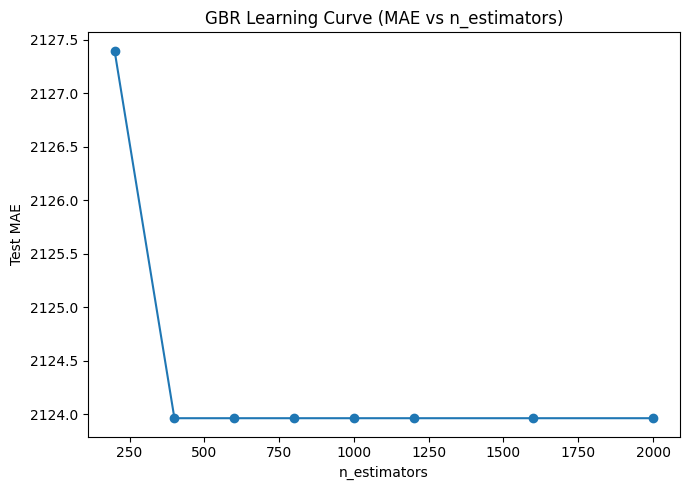

In [40]:
ests = [200, 400, 600, 800, 1000, 1200, 1600, 2000]
mae_curve = []

base = deepcopy(gbr_tuned)
for ne in ests:
    step = deepcopy(base)
    step.set_params(est__n_estimators=ne)
    step.fit(X_train, y_train)
    pred = step.predict(X_test)
    mae_curve.append(mean_absolute_error(y_test, pred))

plt.figure(figsize=(7,5))
plt.plot(ests, mae_curve, marker="o")
plt.title("GBR Learning Curve (MAE vs n_estimators)")
plt.xlabel("n_estimators")
plt.ylabel("Test MAE")
plt.tight_layout()
plt.show()

Tuned HGB — Top  Feature Importances — no feature_importances_ available.


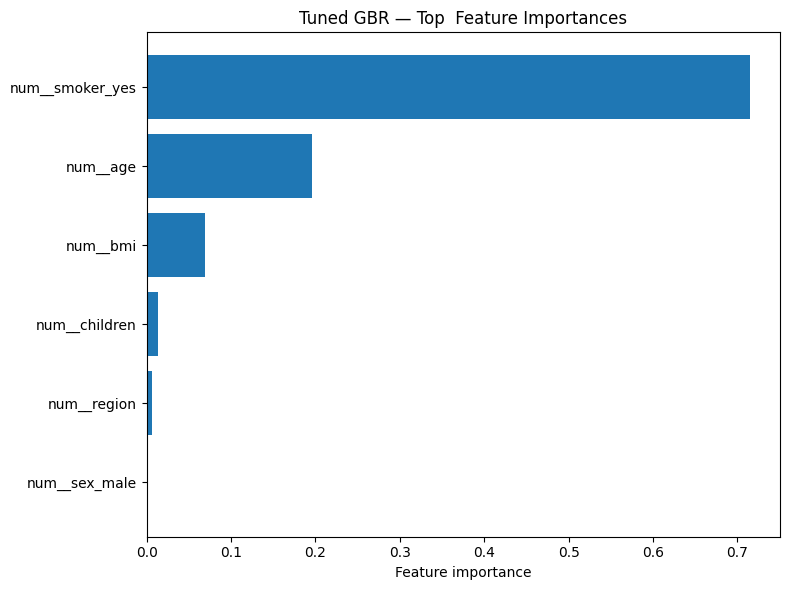

In [42]:
try:
    feature_names = hgb_tuned.named_steps["prep"].get_feature_names_out()
except Exception:
    feature_names = np.array([f"f{i}" for i in range(hgb_tuned.named_steps["prep"].transform(X_train[:1]).shape[1])])

def plot_importances(model, title):
    # Works for tree-based models exposing feature_importances_
    if hasattr(model.named_steps["est"], "feature_importances_"):
        imps = model.named_steps["est"].feature_importances_
        idx  = np.argsort(imps)[::-1][:20]
        names= feature_names[idx]
        vals = imps[idx]
        plt.figure(figsize=(8,6))
        plt.barh(range(len(vals)), vals[::-1])
        plt.yticks(range(len(vals)), names[::-1])
        plt.title(title)
        plt.xlabel("Feature importance")
        plt.tight_layout()
        plt.show()
    else:
        print(title, "— no feature_importances_ available.")

plot_importances(hgb_tuned, "Tuned HGB — Top  Feature Importances")
plot_importances(gbr_tuned, "Tuned GBR — Top  Feature Importances")

In [43]:
best_new_row = tuned_df.iloc[0]
best_new_name = best_new_row["Model"]
print("New best (tuned) candidate:", best_new_name)
print(best_new_row)

# Map to object
name_to_model = {
    "HGB_prev": prev_hgb,
    "HGB_tuned": hgb_tuned,
    "GBR_prev": prev_gbr,
    "GBR_tuned": gbr_tuned
}
final_tuned_model = name_to_model[best_new_name]


joblib.dump(final_tuned_model, "insurance_best_model_tuned.joblib")
tuned_df.to_csv("tuned_candidates_metrics.csv", index=False)

print("\nSaved:")
print(" - insurance_best_model_tuned.joblib")
print(" - tuned_candidates_metrics.csv")

New best (tuned) candidate: HGB_tuned
MAE      2050.535286
RMSE     5643.027073
R2          0.750439
MedAE     167.252684
MAPE       10.162273
Model      HGB_tuned
Name: 0, dtype: object

Saved:
 - insurance_best_model_tuned.joblib
 - tuned_candidates_metrics.csv


In [44]:


REPO_URL   = "https://github.com/yosriawedi/ML-Project-Insurance.git"
BRANCH     = "modelisation-attempt"
LOCAL_DIR  = "/content/ML-Project-Insurance"  # where to clone


import os, getpass, subprocess, shutil, glob
os.environ["GH_TOKEN"] = getpass.getpass("Paste your GitHub token (hidden): ")

Paste your GitHub token (hidden): ··········


In [47]:
!git config --global user.name "$GIT_USER_NAME"
!git config --global user.email "$GIT_USER_EMAIL"